In [12]:
import numpy as np

import ufl
from dolfinx import fem, io, mesh, plot
from ufl import ds, dx, grad, inner

from mpi4py import MPI
from petsc4py.PETSc import ScalarType

In [21]:
msh = mesh.create_rectangle(comm=MPI.COMM_WORLD,
                            points=((0.0, 0.0), (4.0, 1.0)), n=(50, 50),
                            cell_type=mesh.CellType.triangle,)
V = fem.FunctionSpace(msh, ("Lagrange", 1))

In [22]:
anode = mesh.locate_entities_boundary(msh, dim=1,
                                       marker=lambda x: np.isclose(x[0], 0.0))
cathode = mesh.locate_entities_boundary(msh, dim=1,
                                       marker=lambda x: np.isclose(x[0], 1.0))

In [23]:
dofs1 = fem.locate_dofs_topological(V=V, entity_dim=1, entities=anode)
bc_anode = fem.dirichletbc(value=ScalarType(0), dofs=dofs1, V=V)

dofs2 = fem.locate_dofs_topological(V=V, entity_dim=1, entities=anode)
bc_cathode = fem.dirichletbc(value=ScalarType(0), dofs=dofs2, V=V)

In [58]:
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
x = ufl.SpatialCoordinate(msh)
f = x[1] * x[1]
g = 1.0
a = inner(grad(u), grad(v)) * dx
L = inner(f, v) * dx + inner(g, v) * ds

In [59]:
problem = fem.petsc.LinearProblem(a, L, bcs=[bc_anode, bc_cathode], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

INFO:root:running build_ext
INFO:root:building 'libffcx_forms_f586066d94d12c31977138253fe0dbc3aaab48bb' extension
INFO:root:/home/remi/anaconda3/envs/FEM/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/remi/anaconda3/envs/FEM/include -fPIC -O2 -isystem /home/remi/anaconda3/envs/FEM/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/remi/anaconda3/envs/FEM/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/remi/anaconda3/envs/FEM/include -fPIC -I/home/remi/anaconda3/envs/FEM/lib/python3.10/site-packages/ffcx/codegeneration -I/home/remi/anaconda3/envs/FEM/include/python3.10 -c libffcx_forms_f586066d94d12c31977138253fe0dbc3aaab48bb.c -o ./libffcx_forms_f586066d94d12c31977138253fe0dbc3aaab48bb.o -O2 -g0
INFO:root:/home/remi/anaconda3/envs/FEM/bin/x86_64-conda-linux-gnu-cc -shared -Wl,--allow-shlib-undefined -Wl,-rpath,/home/remi/an

In [60]:
with io.XDMFFile(msh.comm, "out_poisson/poisson.xdmf", "w") as file:
    file.write_mesh(msh)
    file.write_function(uh)




No module named 'trame'

Falling back to a static output.
  warnings.warn(



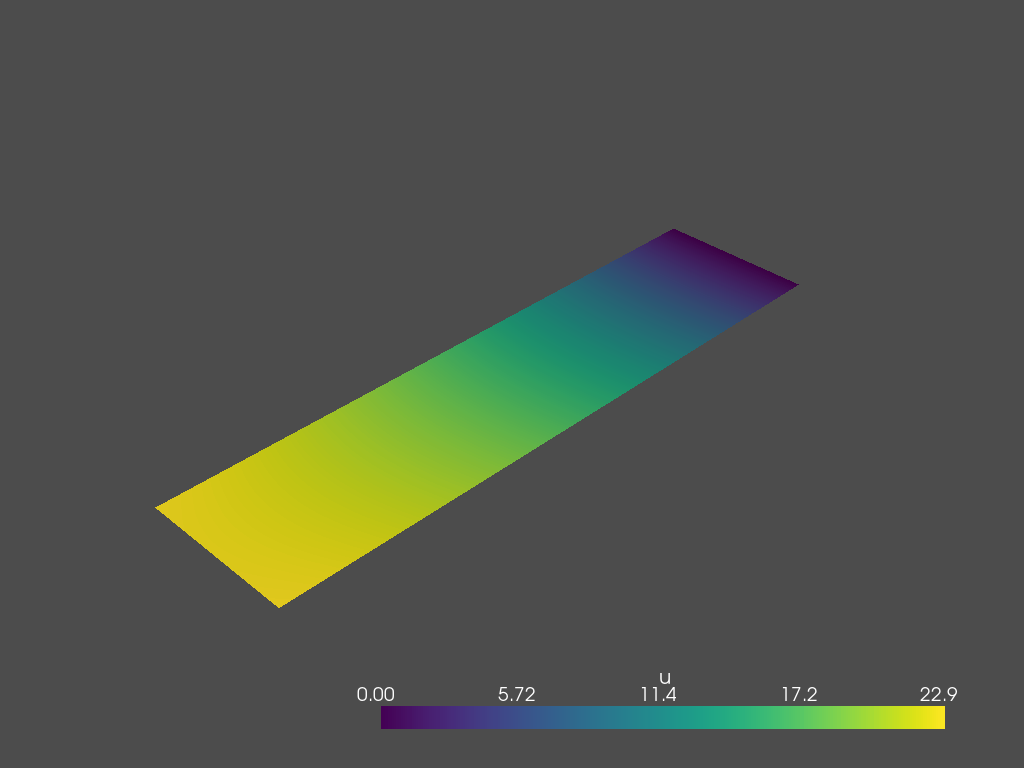

In [61]:
try:
    import pyvista
    cells, types, x = plot.create_vtk_mesh(V)
    grid = pyvista.UnstructuredGrid(cells, types, x)
    grid.point_data["u"] = uh.x.array.real
    grid.set_active_scalars("u")
    plotter = pyvista.Plotter()
    plotter.add_mesh(grid, show_edges=False)
    warped = grid.warp_by_scalar()
    # plotter.add_mesh(warped)
    plotter.show()
except ModuleNotFoundError:
    print("'pyvista' is required to visualise the solution")
    print("Install 'pyvista' with pip: 'python3 -m pip install pyvista'")

In [64]:
uh.x